# Comparativa de Word2Vec, GloVe y FastText para medir la similaridad semántica entre pares de oraciones
## Pablo Valdunciel Sánchez 


## 1. Modelos

Utilizamos el modelo *KeyedVectors* de la librería [*gesim*](https://radimrehurek.com/gensim/index.html) para cargar los vectores pre-entrenados de los diferentes modelos 

In [1]:
from gensim.models import KeyedVectors 

Cargamos los vectores pre-entrenados con modelos Word2Vec, GloVe y FastText. Los vectores pre-entrenados de cada modelo utilizados son:

- **Word2Vec**:  [GoogleNews-vectors-negative300.bin.gz](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)  
- **GloVe**: [Common  Crawl  (840B  tokens,2.2M vocab, cased, 300d vectors)](http://nlp.stanford.edu/data/glove.840B.300d.zip)
- **FastText**: [rawl-300d-2M.vec.zip:  2  million  word  vectors  trained  on  Common  Crawl  (600Btokens)](https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip)

En el caso de los vectores de GloVe, se ha utilizado la función [*glove2word2vec*](https://radimrehurek.com/gensim/scripts/glove2word2vec.html) de la librería *gensim* para convertir el archivo al formato Word2Vec.


In [2]:
PATH_WORD2VEC = './data/embedding/word2vec/GoogleNews-vectors-negative300.bin'
PATH_GLOVE = './data/embedding/glove/glove.840B.300d.w2v.txt'
PATH_FASTTEXT = './data/embedding/fasttext/crawl-300d-2M.vec'

Cargar los tres conjuntos vectores puede llevar varios minutos.

In [3]:
word2vec = KeyedVectors.load_word2vec_format(PATH_WORD2VEC, binary=True)

In [4]:
glove = KeyedVectors.load_word2vec_format(PATH_GLOVE, binary=False)

In [5]:
fasttext = KeyedVectors.load_word2vec_format(PATH_FASTTEXT, binary=False)

## 2. Datos

Haciendo uso de las funciones del módulo *load.py* cargamos los conjuntos de **test** de las tareas STS12, STS13, STS14, STS15 y STS16.

| Tarea |                                         Referencia                                         |
|:------:|:------------------------------------------------------------------------------------------:|
|  STS12 |                        [SemEval 2012 - STS](https://www.cs.york.ac.uk/semeval-2012/task6/)                       |
|  STS13 |                                 [SemEval 2013 - STS](http://ixa2.si.ehu.es/sts/)                                 |
|  STS14 |                 [SemEval 2014 - STS](http://alt.qcri.org/semeval2014/task10/index.php?id=sts-en)                |
|  STS15 | [SemEval 2015 - STS](http://alt.qcri.org/semeval2015/task2/index.php?id=semantic-textual-similarity-for-english) |
|  STS16 |                           [SemEval 2016 - STS](http://alt.qcri.org/semeval2016/task1/)                           |

Todas las funciones del módulo *load.py* llevan a cabo un preprocesamiento de las oraciones según los parámetros que se indiquen. Por defecto, el preprocesamiento de las oraciones se basa en realizar una *tokenización/segmentación* de las mismas. A mayores, existen las siguientes posibilidades:

- **lowercase**: hacer que todas las palabras estén en minúscula.
- **stop_words**: eliminar las palabras que no aportan casi significado semántico como determinantes, preprosiciones, etc.
- **punctuation**: elminar los símbolos de puntuación.
- **only_ascci**: eliminar las palabras que no estén formadas por caracteres ASCII.
- **lemmatization**: sustituir las palabras por su lexema.

El preprocesamiento del texto está implementado en la función *preprocess* en el módulo *utils.py*. La función *preprocess* hace uso de la librería [spaCy](https://spacy.io/) para llevar a cabo el preprocesamiento.

In [13]:
from load import load_sts_12, load_sts_13, load_sts_14, load_sts_15, load_sts_16
from load import load_frequencies

En este caso, tan solo se realiza la *tokenización/segmentación* de las oraciones y no se aplica ningún otro preprocesamiento.

In [14]:
PATH_DATASETS = './data/datasets/STS'
PATH_FREQUENCIES = './data/frequencies.tsv'
PREPROCESSING =  {'lowercase':  False, 
                  'stop_words': False, 
                  'punctuation': False, 
                  'only_ascii': False, 
                  'lemmatization': False
                 }

Cargamos también las frecuencias de las palabras en el corpus para poder aplicar el SIF.

In [15]:
freqs = load_frequencies(PATH_FREQUENCIES)

In [16]:
sts12 = load_sts_12(PATH_DATASETS, PREPROCESSING, verbose=True)
sts13 = load_sts_13(PATH_DATASETS, PREPROCESSING, verbose=True)
sts14 = load_sts_14(PATH_DATASETS, PREPROCESSING, verbose=True)
sts15 = load_sts_15(PATH_DATASETS, PREPROCESSING, verbose=True)
sts16 = load_sts_16(PATH_DATASETS, PREPROCESSING, verbose=True)


***** TASK: STS12 *****

Preprocessing -MSRpar-
-MSRpar- preprocessed correctly
Preprocessing -MSRvid-
-MSRvid- preprocessed correctly
Preprocessing -SMTeuroparl-
-SMTeuroparl- preprocessed correctly
Preprocessing -surprise.OnWN-
-surprise.OnWN- preprocessed correctly
Preprocessing -surprise.SMTnews-
-surprise.SMTnews- preprocessed correctly

***** TASK: STS13 (-SMT) ***


Preprocessing -FNWN-
-FNWN- preprocessed correctly
Preprocessing -headlines-
-headlines- preprocessed correctly
Preprocessing -OnWN-
-OnWN- preprocessed correctly

***** TASK: STS14 *****

Preprocessing -deft-forum-
-deft-forum- preprocessed correctly
Preprocessing -deft-news-
-deft-news- preprocessed correctly
Preprocessing -headlines-
-headlines- preprocessed correctly
Preprocessing -images-
-images- preprocessed correctly
Preprocessing -OnWN-
-OnWN- preprocessed correctly
Preprocessing -tweet-news-
-tweet-news- preprocessed correctly

***** TASK: STS15 *****

Preprocessing -answers-forums-
-answers-forums- prepro

## 3. Métodos

Los métodos para calcular la similaridad semántica entre dos oraciones se encuentran en el módulo *methods.py* y son:

- **avg_cosine**: el vector de una oración se obtiene haciendo la media (*average*) de los vectores de las palabras de esa oración. La similaridad entre dos vectores se calcula utilizando la similitud coseno.
- **sif_cosine**: el vector de una oración se obtiene haciendo una media ponderada (*Smooth Inverse Frequency*, SIF) de los vectores de las palabras de esa oración. La similaridad entre dos vectores se calcula utilizando la similitud coseno.
- **wmd**: la similariad entre dos oraciones se calcula como el contrario de la distancia *Word Mover's Distance* entre las mismas. El modelo *KeyedVectors* de *gensim* incorpora el cálculo de esta distancia ([ver método](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.wmdistance)). Esta distancia no está acotada y tomará el valor *infinito* cuando ninguna de las palabras de alguna de las dos oraciones este presente en el modelo, por ello se ha acotado en el intervalo [0, 100].

In [17]:
from functools import partial
from methods import avg_cosine, wmd, sif_cosine

In [111]:
METHODS = [
    ("W2V + AVG", partial(avg_cosine, model=word2vec)),
    ("W2V + SIF", partial(sif_cosine, model=word2vec, frequencies=freqs, a=0.001)),
    ("W2V + WMD", partial(wmd, model=word2vec)),   
    ("GLOVE + AVG", partial(avg_cosine, model=glove)),
    ("GLOVE + SIF", partial(sif_cosine, model=glove, frequencies=freqs, a=0.001)),
    ("GLOVE + WMD", partial(wmd, model=glove)),    
    ("FT + AVG", partial(avg_cosine, model=fasttext)),
    ("FT + SIF", partial(sif_cosine, model=fasttext, frequencies=freqs, a=0.001)),
    ("FT + WMD", partial(wmd, model=fasttext))    
]

## 4. Evaluación

En el módulo *utils.py* se encuentra la función *evaluate* que calcula los coeficientes de correlación de Pearson y Spearman entre las puntuaciones *Gold Standard* de una tarea y las mediadas de similariad proporcionadas por uno o varios métodos.

In [112]:
from utils import evaluate
from scipy.stats import rankdata, chi2
from Orange.evaluation import compute_CD, graph_ranks
import numpy as np
import pprint
import matplotlib.pyplot as plt

In [113]:
N = 5  # Número de conjuntos de datos
K = 9  # Número de métodos

In [114]:
sts12_pearson, sts12_spearman = evaluate(sts12, METHODS)
sts13_pearson, sts13_spearman = evaluate(sts13, METHODS)
sts14_pearson, sts14_spearman = evaluate(sts14, METHODS)
sts15_pearson, sts15_spearman = evaluate(sts15, METHODS)
sts16_pearson, sts16_spearman = evaluate(sts16, METHODS)

### Coeficientes de correlación de Pearson

En la siguiente tabla podemos observar los coeficientes de correlación de Pearson obtenidos por cada uno de los métodos sobre cada tarea.

In [116]:
pearson_corr = np.array([ np.array(list(sts12_pearson.values())), 
                                  np.array(list(sts13_pearson.values())),
                                  np.array(list(sts14_pearson.values())),
                                  np.array(list(sts15_pearson.values())),
                                  np.array(list(sts16_pearson.values()))])

<table style="border-collapse:collapse;border-spacing:0" class="tg"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">Corpus \ Método</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">W2V + AVG</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">W2V + SIF</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">W2V + WMD</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">GLOVE + AVG</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">GLOVE+SIF</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">GLOVE + WMD</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">FT + AVG</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">FT + SIF</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">FT + WMD</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;font-weight:bold;text-align:center;vertical-align:top">STS12</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,5577</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,5670</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,4735</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,5503</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,5887</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,5511</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6006</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6213</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,5535</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;font-weight:bold;text-align:center;vertical-align:top">STS13</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6402</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,7227</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,5212</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,5431</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,7004</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,4865</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6396</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,7431</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,5043</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;font-weight:bold;text-align:center;vertical-align:top">STS14</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6868</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,7279</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6122</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,5625</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,7069</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,5803</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6664</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,7356</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,5921</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;font-weight:bold;text-align:center;vertical-align:top">STS15</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,7049</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,7490</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6839</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6006</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,7319</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6796</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6999</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,7613</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6888</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;font-weight:bold;text-align:center;vertical-align:top">STS16</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6391</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,7191</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6408</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,5025</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6847</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6133</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6326</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,7315</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:inherit;text-align:center;vertical-align:top">0,6312</td></tr></table>

### Rankings 


Calculamos los rankings para cada tarea y los rankings promedios.

In [96]:
ranks = np.array([np.array(rankdata((-1)*pearson_corr[task])) for task in range(pearson_corr.shape[0])])
avg_ranks = np.average(ranks, axis=0)

En la siguiente tabla podemos observar los rankings obtenidos:

<table style="border-collapse:collapse;border-spacing:0" class="tg"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">Corpus \ Método</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">W2V + AVG</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">W2V + SIF</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">W2V + WMD</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">GLOVE + AVG</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">GLOVE+SIF</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">GLOVE + WMD</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">FT + AVG</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">FT + SIF</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">FT + WMD</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;font-weight:bold;text-align:center;vertical-align:top">STS12</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">5</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">4</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">9</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">8</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">3</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">7</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">2</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">1</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">6</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;font-weight:bold;text-align:center;vertical-align:top">STS13</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">4</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">2</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">7</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">6</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">3</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">9</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">5</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">1</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">8</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;font-weight:bold;text-align:center;vertical-align:top">STS14</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">4</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">2</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">6</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">9</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">3</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">8</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">5</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">1</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">7</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;font-weight:bold;text-align:center;vertical-align:top">STS15</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">4</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">2</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">7</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">9</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">3</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">8</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">5</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">1</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">6</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;font-weight:bold;text-align:center;vertical-align:top">STS16</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">5</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">2</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">4</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">9</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">3</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">8</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">6</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">1</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;text-align:center;vertical-align:top">7</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;font-weight:bold;background-color:#baeeaa;text-align:center;vertical-align:top">Promedio</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;background-color:#baeeaa;text-align:center;vertical-align:top">4,4</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;background-color:#baeeaa;text-align:center;vertical-align:top">2,4</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;background-color:#baeeaa;text-align:center;vertical-align:top">6,6</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;background-color:#baeeaa;text-align:center;vertical-align:top">8,2</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;background-color:#baeeaa;text-align:center;vertical-align:top">3</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;background-color:#baeeaa;text-align:center;vertical-align:top">8</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;background-color:#baeeaa;text-align:center;vertical-align:top">4,6</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;background-color:#baeeaa;text-align:center;vertical-align:top">1</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;background-color:#baeeaa;text-align:center;vertical-align:top">6,8</td></tr></table>

### Test de Friedman

In [88]:
sqr_avg_ranks = np.array(list(map(lambda r: r**2, avg_ranks)))
friedman = (12*N) / (K*(K+1)) * (sum(sqr_avg_ranks) - (K*(K+1)**2/4))
p_value = 1 - chi2.cdf(friedman, K-1)

print("p-valor = {:4f}".format(p_value))

p-valor = 0.000028


### Test de Nemenyi

Calculamos la distancia crítica de Nemenyi y representamos las diferencias significativas.

In [93]:
cd_nemenyi = compute_CD(avg_ranks, N, alpha='0.05', test='nemenyi') 
print("Distancia crítica de Nemenyi (alpha = 0.05) = ", cd_nemenyi)

Distancia crítica de Nemenyi (alpha = 0.05) =  5.372353951360613


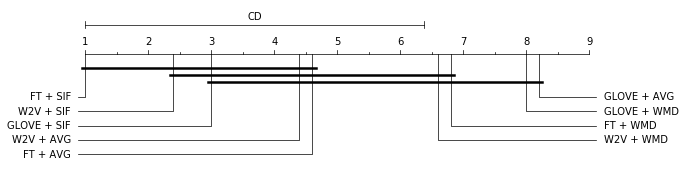

In [74]:
graph_ranks(avg_ranks, list(sts12_pearson.keys()), cd=cd_nemenyi, width=9, textspace=1)
plt.show()

### Test de Bonferroni-Dunn

Dado que el método *FT + SIF* ha obtenido la primera posición para todos los conjuntos de datos, parece razonable utiizar el Test de Bonferroni-Dunn para comparar este método con los demás.

In [68]:
cd_bonferroni_dunn = compute_CD(avg_ranks, N, alpha='0.05', test='bonferroni-dunn') 
print("Distancia crítica de Bonferroni-Dunn (alpha = 0.05) = ", cd_bonferroni_dunn)

Distancia crítica de Bonferroni-Dunn (alpha = 0.05) =  4.718106399817622


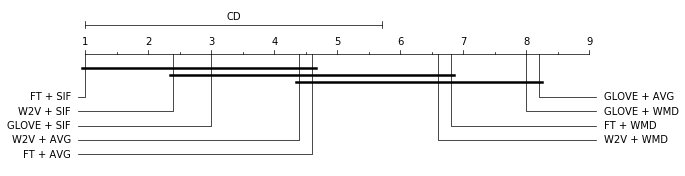

In [75]:
graph_ranks(avg_ranks, list(sts12_pearson.keys()), cd=cd_bonferroni_dunn, width=9, textspace=1)
plt.show()

### Concluiones